# Figure Creator

In [1]:
import time
import json  # for checkpointing
import csv

from collections import Counter

from pathlib import Path

import numpy as np
# import scipy.sparse
# import torch
# import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tqdm.notebook import trange, tqdm

import pandas as pd

# import datetime

# import os
# from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

# load_dotenv(find_dotenv('config.env'))

# torch.cuda.current_device()
# torch.cuda.device(0)
# torch.cuda.device_count()
# torch.cuda.get_device_name(0)
# torch.cuda.is_available()

# import sklearn
# import sklearn.metrics
import seaborn as sns

In [2]:
diverging_palette_dark = sns.diverging_palette(250, 15, s=75, l=40, n=2, center="dark")
diverging_palette_light = sns.diverging_palette(240, 10, n=2, center="light")
diverging_palette_heatmap = sns.color_palette("icefire", as_cmap=True)

display(diverging_palette_dark)
display(diverging_palette_light)
display(diverging_palette_heatmap)

[(0.20651240887022015, 0.3755393698154809, 0.5856904756194529),
 (0.6565296443848212, 0.21867290090002556, 0.1744737357010414)]

[(0.2564697186166857, 0.4871591358142198, 0.657003695890986),
 (0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

In [3]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

# Selected Model Loading

In [4]:
model_paths = {
#     'FFO-POOL':             Path('model_checkpoints/FFO-POOL-2021-05-07'),
#     'MHA-1':           Path('model_checkpoints/MHA-1-POOL-2021-05-05'),
#     'MHA-11':          Path('model_checkpoints/MHA-11-POOL-2021-05-06'),
#     'MHA-34-NEW':          Path('model_checkpoints/MHA-34-POOL-NEW-2021-05-11'),
#     'MHA-34':          Path('model_checkpoints/MHA-34-POOL-2021-05-05'),
#     'MHA-34-B': Path('model_checkpoints/MHA-34-POOL-BALANCED-2021-05-08'),
#     'MHA-34-DISCARDS':      Path('model_checkpoints/MHA-34-DISCARDS-2021-05-07'),
    'FFO-B'  : Path('model_checkpoints/FFO-FINAL-BIG-2021-05-15'),
    'MHA-B'  : Path('model_checkpoints/MHA-1-FINAL-BIG-2021-05-14'),
    'MHA-S'  : Path('model_checkpoints/MHA-1-FINAL-SMALL-2021-05-14'),
}

for name, path in model_paths.items():
    print(name)
    assert path.exists()

FFO-B
MHA-B
MHA-S


# Model Training/Validation Results Table

In [5]:
df_summaries = []

for name, path in model_paths.items():
    temp_df = pd.read_csv(path / 'summary.csv')
    temp_df['model'] = name

    
    df_summaries.append(temp_df)

df = pd.concat(df_summaries)
# df

## Model Summary Table

In [6]:
temp_df = df[['model',
              'epoch', 
              'train_loss',
              'train_acc',
              'val_loss',
              'val_acc',
              'time_elapsed']].set_index(['model', 'epoch'])

# Get Average Time/Epoch
temp_df['time_elapsed'] = pd.to_timedelta(temp_df['time_elapsed'])
avg_time = temp_df.groupby('model')['time_elapsed'].mean(numeric_only=False)
avg_time = avg_time.dt.seconds.apply(seconds_to_hhmmss)

# Get Model rows with lowest val_loss
new = temp_df.loc[temp_df.groupby('model')['val_loss'].idxmin()]
new = new.drop(columns='time_elapsed')
new = new.reset_index().set_index('model')

# Merge calculated average time
new['avg_time_per_epoch'] = avg_time
new = new.reset_index()  # Makes index printing leveled with other columns
new

,model,epoch,train_loss,train_acc,val_loss,val_acc,avg_time_per_epoch
0,FFO-B,17,1.693245,0.442137,1.500546,0.483861,00:52:16
1,MHA-B,15,0.813698,0.698596,0.904523,0.664393,01:11:06
2,MHA-S,13,0.861076,0.684187,0.940452,0.659131,00:35:22


In [7]:
lstr = new.to_latex(index=False,
                    index_names=False, 
                    float_format="%.3f", 
                    bold_rows=True,
                   )

print(lstr)

\begin{tabular}{lrrrrrl}
\toprule
 model &  epoch &  train\_loss &  train\_acc &  val\_loss &  val\_acc & avg\_time\_per\_epoch \\
\midrule
 FFO-B &     17 &       1.693 &      0.442 &     1.501 &    0.484 &           00:52:16 \\
 MHA-B &     15 &       0.814 &      0.699 &     0.905 &    0.664 &           01:11:06 \\
 MHA-S &     13 &       0.861 &      0.684 &     0.940 &    0.659 &           00:35:22 \\
\bottomrule
\end{tabular}



# Model Graph

In [8]:
# sns.set_style("ticks")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("whitegrid")
# sns.set_style("darkgrid")

# sns.set_palette('bright')

### Non-Attention-Based Model - TRAINING VS VALIDATION

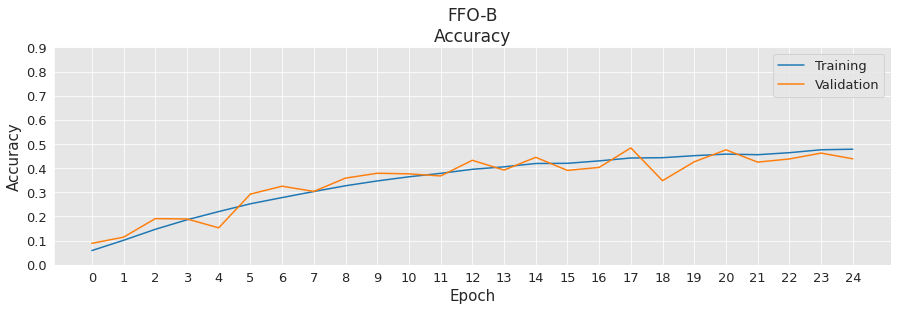

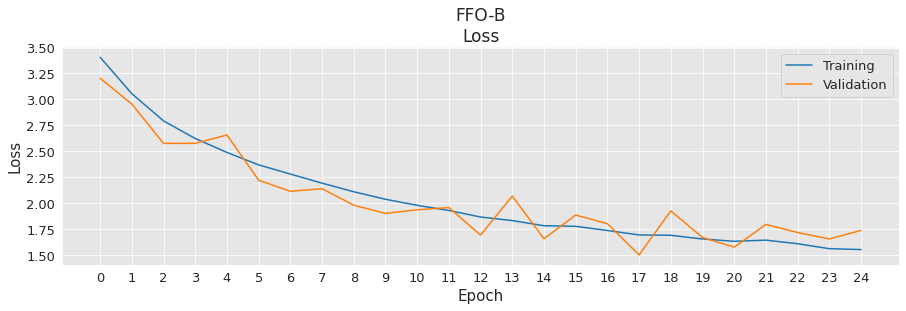

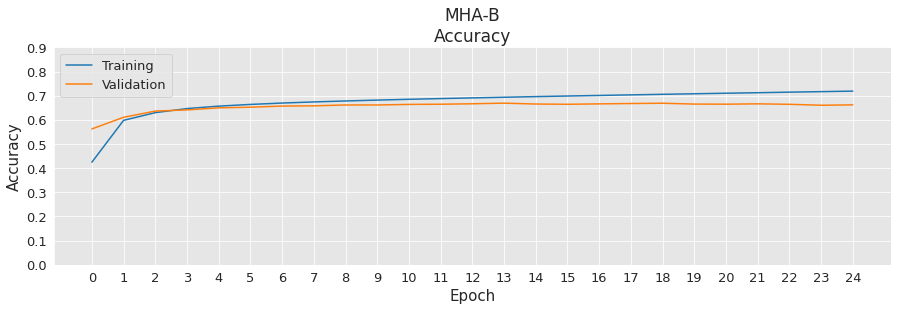

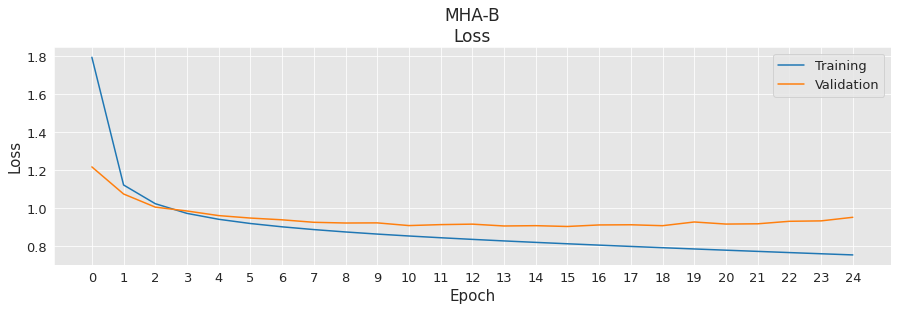

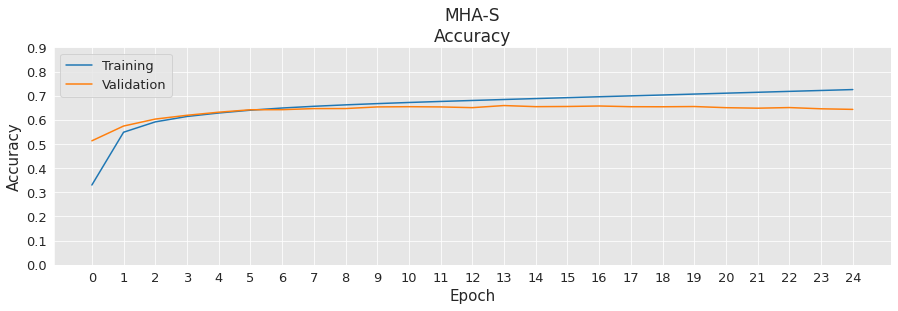

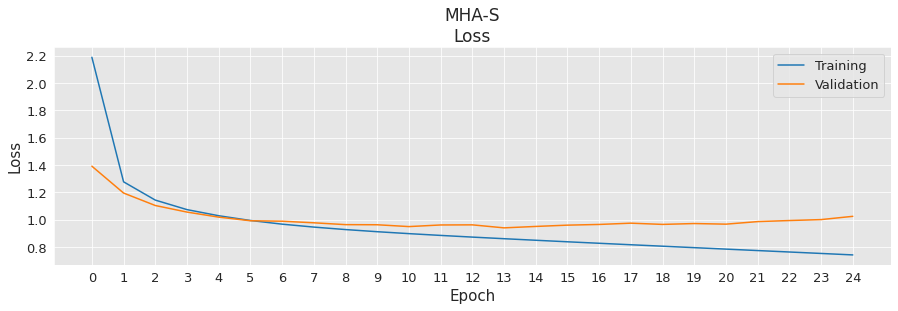

In [10]:
def draw_training_validation(model_name, epochs, title: str):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 13
    figsize = (15, 4)
    
    EPOCHS = len(df[df.model == model_name]) if epochs == -1 else epochs
    
    # ACCURACY
    figure = plt.figure(figsize=figsize)
    ax = plt.axes()

    plt.plot(df[df.model == model_name]['train_acc'][0:EPOCHS], label='Training')
    plt.plot(df[df.model == model_name]['val_acc'][0:EPOCHS], label='Validation')

    plt.title(f'{title}\nAccuracy', fontsize=title_fontsize)
    plt.xlabel('Epoch', fontsize=label_fontsize)
    plt.ylabel('Accuracy', fontsize=label_fontsize)
    plt.legend(fontsize=legend_fontsize)

    step = range(EPOCHS)
    plt.xticks(step, fontsize=ticks_fontsize)
    plt.yticks(np.arange(0.0, 1.0, 0.1), fontsize=ticks_fontsize)


    plt.savefig(Path('figures') / f"{model_name}_train_val_acc.png", bbox_inches='tight')

    plt.show()
    
    # LOSS
    figure = plt.figure(figsize=figsize)
    ax = plt.axes()

    plt.plot(df[df.model == model_name]['train_loss'][0:EPOCHS], label='Training')
    plt.plot(df[df.model == model_name]['val_loss'][0:EPOCHS], label='Validation')

    plt.title(f'{title}\nLoss', fontsize=title_fontsize)
    plt.xlabel('Epoch', fontsize=label_fontsize)
    plt.ylabel('Loss', fontsize=label_fontsize)
    plt.legend(fontsize=legend_fontsize)

    step = range(EPOCHS)
    plt.xticks(step, fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)

    plt.savefig(Path('figures') / f"{model_name}_train_val_loss.png", bbox_inches='tight')

    plt.show()
    
    
    
draw_training_validation(model_name='FFO-B', epochs=25, title='FFO-B')
draw_training_validation(model_name='MHA-B', epochs=25, title='MHA-B')
draw_training_validation(model_name='MHA-S', epochs=25, title='MHA-S')

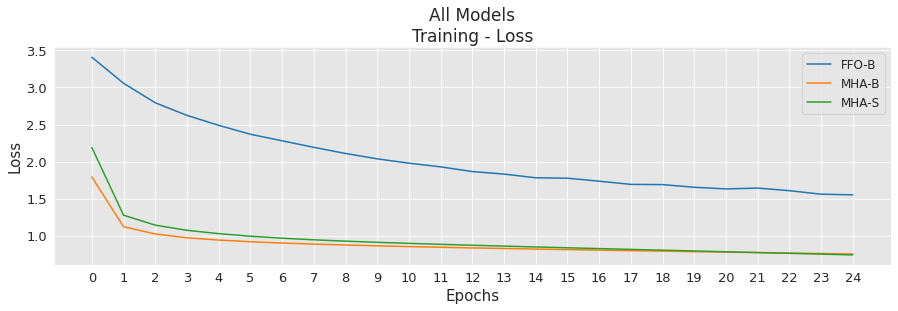

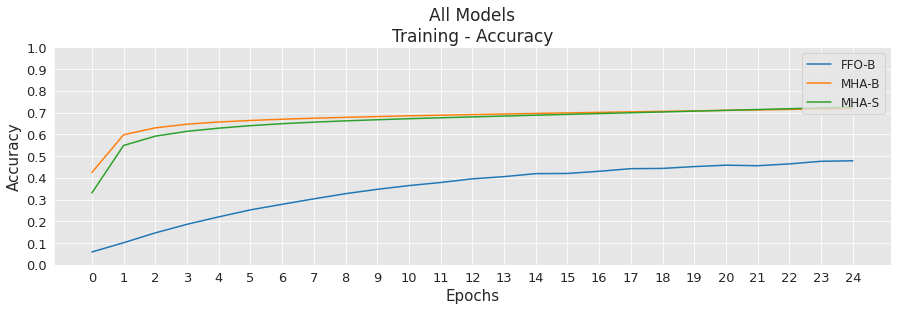

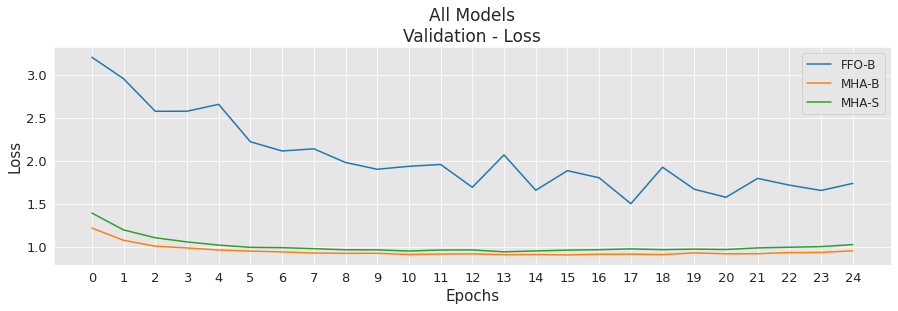

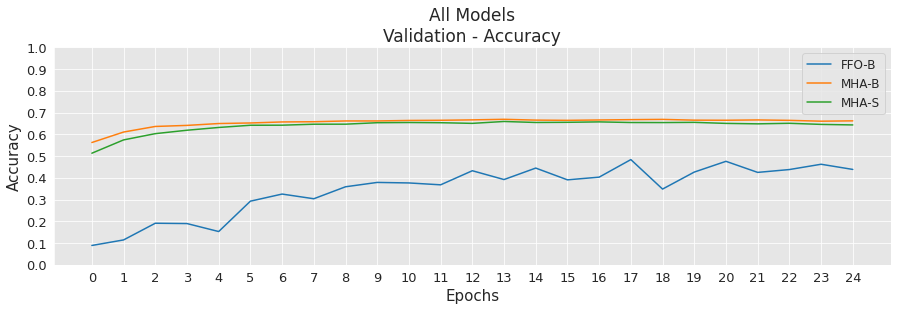

In [11]:
def annot_extreme(_ax, xmax, ymax, xcoord, ycoord):

    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60",color='black')
    kw = dict(arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top", annotation_clip=False)
    _ax.annotate(text, xy=(xmax, ymax), xytext=(xcoord, ycoord), xycoords='data', **kw)

def plot_summary(summaries: pd.DataFrame, column_name: str, title: str, y_label: str, annot_coords: list = None, epochs=25):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 12
    figsize = (15, 4)

    figure = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    
    for i, summary in enumerate([y for x, y in summaries.groupby('model', as_index=False)]):
        plt.plot(summary[column_name][0:epochs], label=summary['model'][0])
    
        if annot_coords is not None:
            x, y = annot_coords[i]
            max_y = summary[column_name][0:epochs].max()
            max_x = summary[column_name][0:epochs].argmax()
            annot_extreme(ax, max_x, max_y, x, y)

    plt.title('All Models\n' + title, fontsize=title_fontsize)
    plt.xlabel('Epochs', fontsize=label_fontsize)
    plt.ylabel(y_label,  fontsize=label_fontsize)
    plt.legend(loc='upper right', fontsize=legend_fontsize)
    
    step = range(epochs)
    plt.xticks(step, fontsize=ticks_fontsize)
    

    
    if y_label == 'Accuracy':
        plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=ticks_fontsize)
    else:
        plt.yticks(fontsize=ticks_fontsize)

    file_name = title.replace(' ', '').replace('-', '_').lower()
    plt.savefig(Path('figures') / f'ALL_{file_name}.png', bbox_inches='tight')
    
    plt.show()
    plt.close()


# filtered_df = df[df.model != 'MHA-S']  # Filtering away certain models
filtered_df = df

# Training
plot_summary(summaries=filtered_df,
             column_name='train_loss', 
             title='Training - Loss', 
             y_label='Loss')

plot_summary(summaries=filtered_df,
             column_name='train_acc', 
             title='Training - Accuracy', 
             y_label='Accuracy')

# Validation
plot_summary(summaries=filtered_df,
             column_name='val_loss', 
             title='Validation - Loss', 
             y_label='Loss')

plot_summary(summaries=filtered_df,
             column_name='val_acc', 
             title='Validation - Accuracy', 
             y_label='Accuracy',
#             annot_coords=[(17, 0.2),
#                           (5, 1),
#                           (5, 0.6)
#                          ]
            )

# Valid Class Heatmaps
Copied from the original `model.ipynb`

In [14]:
def graph_heatmap(df, model_name: str, mode: int, epoch: int):
    
    filtered_df = df[(df['mode'] == mode) & (df['epoch'] == epoch)]
    
    assert len(filtered_df) == 14, f"NOT ENOUGH ROWS FOR HEATMAP! EXPECTED 14, got {len(filtered_df)}"
    
    plt.figure(figsize=(19, 6))
    ax = sns.heatmap(filtered_df.drop(columns=['mode', 'epoch', 'n_valid']), 
                     annot=True, 
                     fmt=".1f", 
                     cmap="icefire",  # icefire, coolwarm
                     center=0.5,
#                      linewidths=.2,
#                      linecolor='black',
                     annot_kws={"fontsize":12},
                     vmin=0.0, vmax=1.0,
#                      square=True,
                     xticklabels=range(0, 34),
                     yticklabels=range(1, 15),
                     cbar=False,
                     cbar_kws=dict(shrink=0.4, label='Average propability', ticks=np.arange(0.0, 1.2, 0.2))
                )

#     ax.vlines(range(1, 34), -1, 15, linewidth=2, color="black")

    ax.hlines(range(1, 15), -0.2, 34, linewidth=3, color="white")
    
    mode = 'Training' if mode == 0 else 'Validation'
    plt.title(f"Valid class occurrence heatmap\n{model_name} - {mode} - Epoch {epoch}", fontsize=18)
    
    plt.xlabel('Prediction priority', fontsize=16)
    plt.ylabel('Number of valid classes', fontsize=16)
    
    plt.yticks(rotation=0, fontsize=14, va="center")
    plt.xticks(fontsize=14)
    
    plt.savefig(Path('figures') / f'{model_name}_heatmap_{mode.lower()}_epoch-{epoch}.png', bbox_inches='tight')

    plt.show()

Epoch with lowest val_loss: 17


,mode,epoch,n_valid,h_0,h_1,h_2,h_3,h_4,h_5,h_6,...,h_24,h_25,h_26,h_27,h_28,h_29,h_30,h_31,h_32,h_33
0,0,0,1,0.063830,0.127660,0.000000,0.021277,0.021277,0.063830,0.042553,...,0.021277,0.042553,0.000000,0.063830,0.042553,0.021277,0.042553,0.021277,0.021277,0.000000
1,0,0,2,0.121989,0.098789,0.090376,0.088337,0.080306,0.078776,0.072148,...,0.039643,0.037349,0.040535,0.049331,0.044869,0.044487,0.047036,0.044869,0.034544,0.032887
2,0,0,3,0.231343,0.180288,0.155578,0.141822,0.131163,0.124533,0.117138,...,0.052326,0.050751,0.050299,0.062915,0.058982,0.057268,0.052900,0.048071,0.042399,0.038971
3,0,0,4,0.287579,0.240670,0.215085,0.198400,0.185129,0.175652,0.168397,...,0.066656,0.064008,0.061736,0.063933,0.060361,0.057148,0.052504,0.048691,0.043293,0.039214
4,0,0,5,0.334997,0.288543,0.260192,0.241116,0.226930,0.215483,0.205440,...,0.086077,0.083277,0.080396,0.086196,0.082021,0.077756,0.071570,0.067318,0.059352,0.052670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,24,10,0.974128,0.872661,0.774679,0.719633,0.662385,0.640550,0.645872,...,0.006606,0.003486,0.003670,0.002202,0.000917,0.001284,0.001101,0.000550,0.000550,0.000000
696,1,24,11,0.967009,0.873580,0.770416,0.705516,0.673202,0.657788,0.656842,...,0.013521,0.010681,0.006490,0.005408,0.003245,0.002704,0.002434,0.001082,0.000406,0.000000
697,1,24,12,0.970172,0.870607,0.772269,0.697494,0.667665,0.670390,0.668755,...,0.027104,0.022746,0.014029,0.009670,0.007355,0.006674,0.003950,0.001907,0.001907,0.000272
698,1,24,13,0.969548,0.879226,0.775742,0.701677,0.689548,0.674323,0.672000,...,0.053419,0.045935,0.032000,0.022452,0.014194,0.010323,0.009290,0.005161,0.002323,0.000774


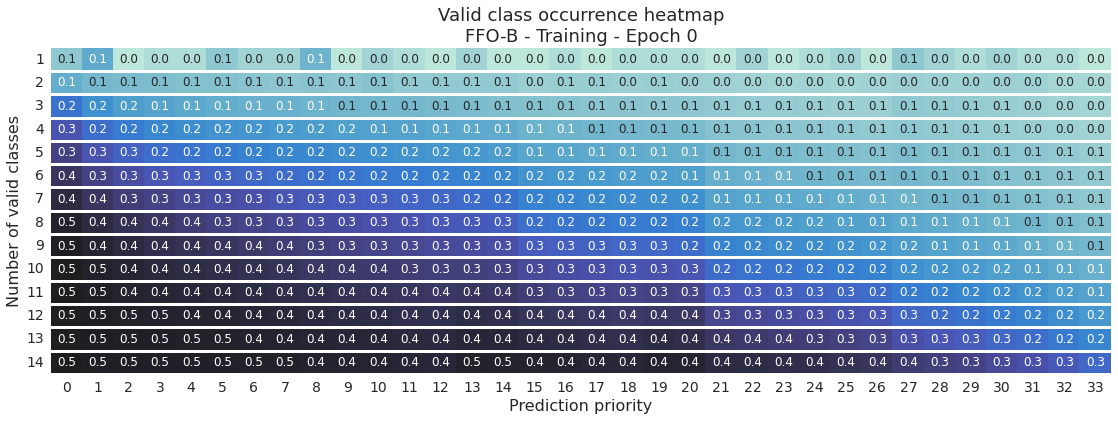

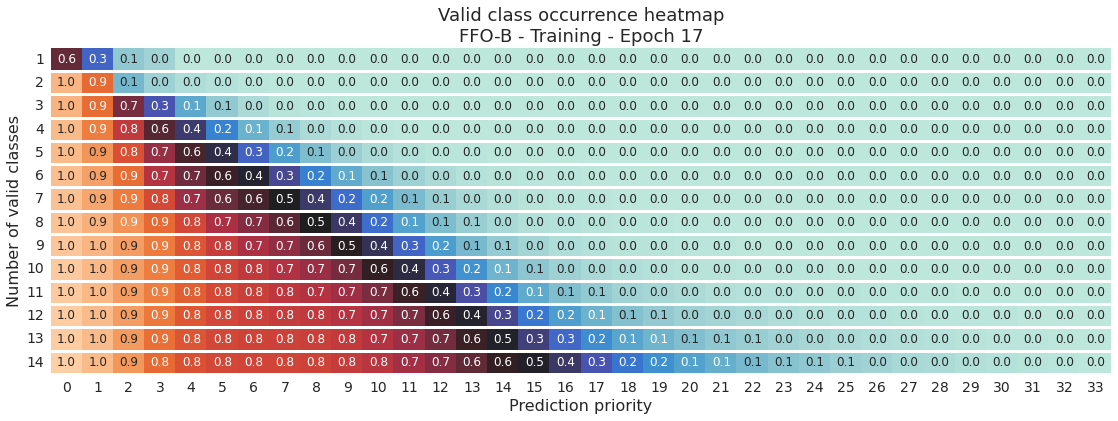

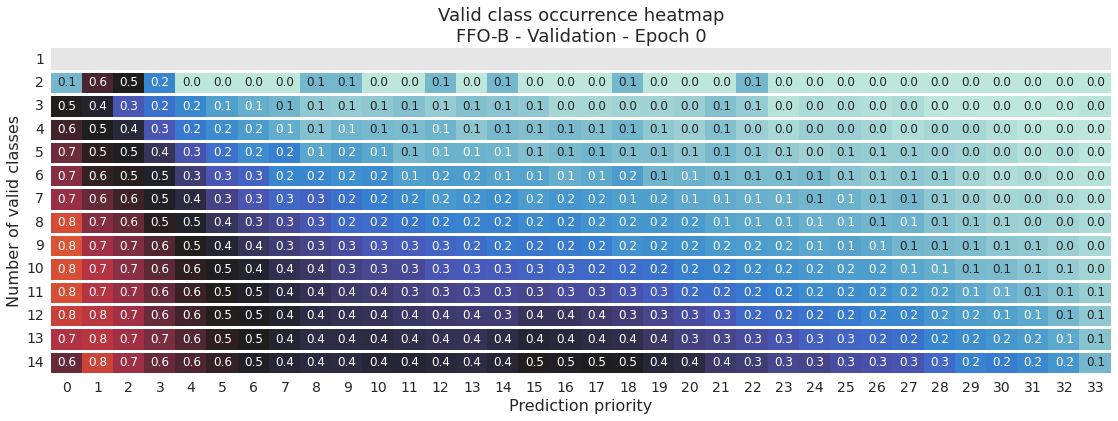

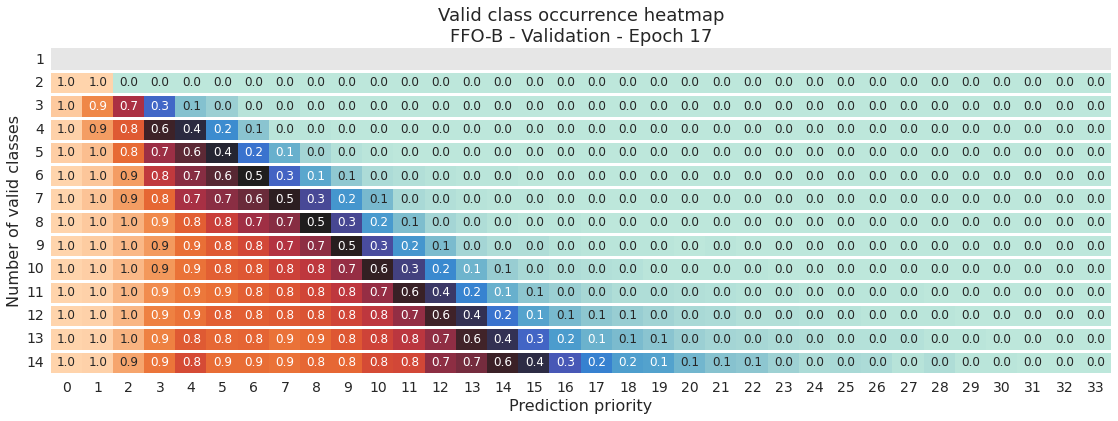

Epoch with lowest val_loss: 15


,mode,epoch,n_valid,h_0,h_1,h_2,h_3,h_4,h_5,h_6,...,h_24,h_25,h_26,h_27,h_28,h_29,h_30,h_31,h_32,h_33
0,0,0,1,0.680851,0.000000,0.021277,0.000000,0.021277,0.042553,0.000000,...,0.021277,0.021277,0.000000,0.000000,0.000000,0.021277,0.000000,0.021277,0.000000,0.000000
1,0,0,2,0.836839,0.804589,0.023454,0.021797,0.017208,0.013129,0.011982,...,0.009178,0.008923,0.008286,0.010453,0.009433,0.010580,0.011472,0.008668,0.006756,0.006883
2,0,0,3,0.848181,0.821339,0.712850,0.080221,0.043799,0.032976,0.028303,...,0.011807,0.011763,0.012294,0.014252,0.014582,0.013860,0.012338,0.011755,0.009684,0.007874
3,0,0,4,0.857103,0.838752,0.807434,0.689698,0.118005,0.063641,0.047818,...,0.014413,0.014307,0.014222,0.014319,0.013541,0.012854,0.011448,0.010692,0.009386,0.007864
4,0,0,5,0.864705,0.847815,0.823247,0.764817,0.607235,0.174531,0.101545,...,0.019068,0.018365,0.017820,0.019272,0.018863,0.017535,0.015889,0.014830,0.012628,0.010169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,24,10,0.999817,0.998899,0.997064,0.988991,0.970459,0.935596,0.884404,...,0.015596,0.011927,0.011193,0.008257,0.006789,0.007339,0.003670,0.003303,0.003119,0.000550
696,1,24,11,0.999865,1.000000,0.998242,0.994997,0.981206,0.955787,0.910087,...,0.024337,0.019470,0.017036,0.015143,0.013791,0.008248,0.007166,0.005003,0.004327,0.002163
697,1,24,12,1.000000,0.999455,0.997412,0.992373,0.976846,0.953419,0.909017,...,0.045492,0.039090,0.031871,0.030237,0.027377,0.017570,0.013212,0.011305,0.007764,0.003269
698,1,24,13,1.000000,0.999742,0.998194,0.991226,0.972903,0.937548,0.889806,...,0.083355,0.065290,0.051097,0.043097,0.046710,0.035097,0.026323,0.020129,0.010839,0.003871


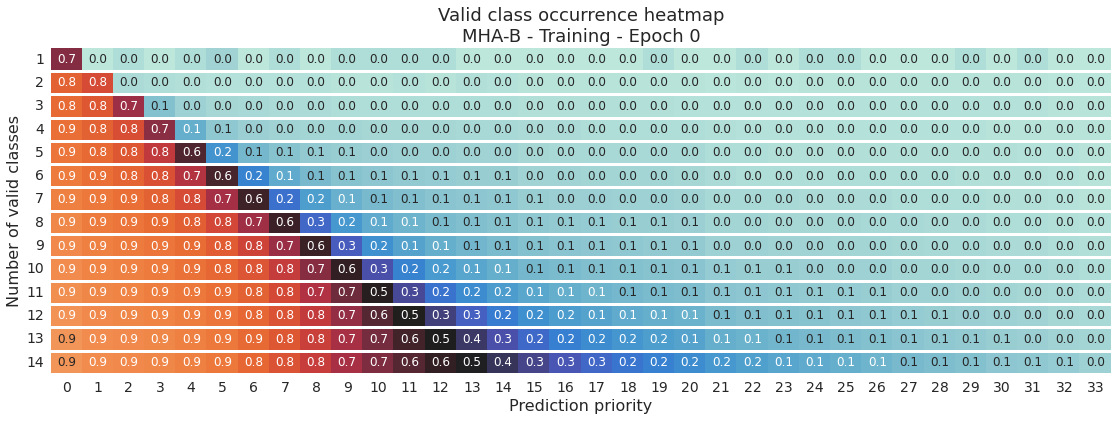

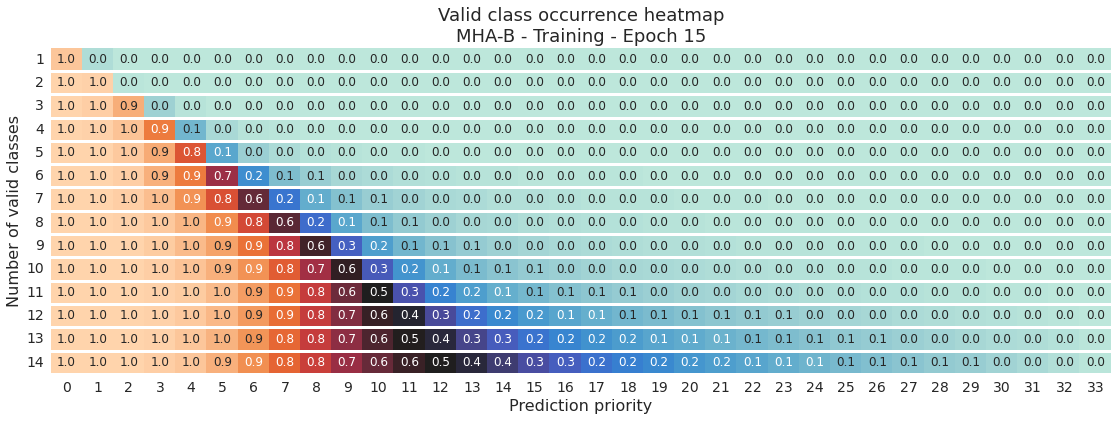

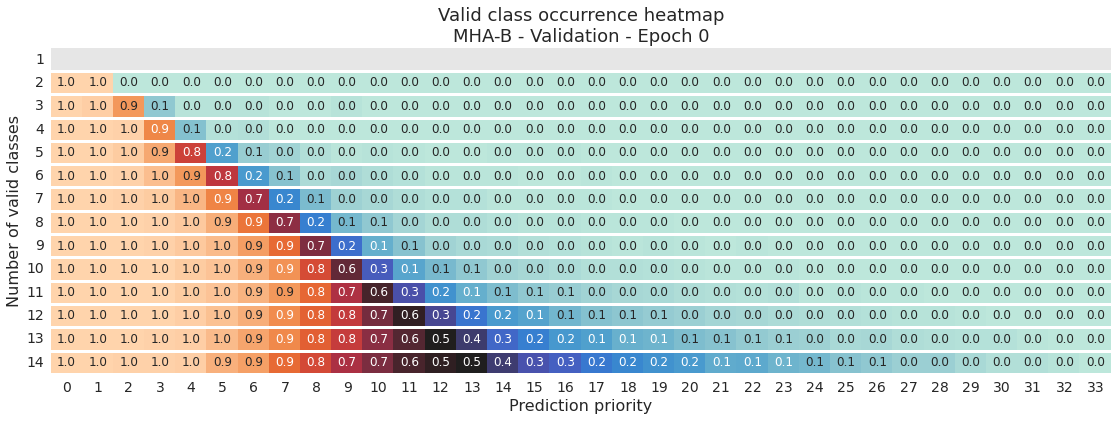

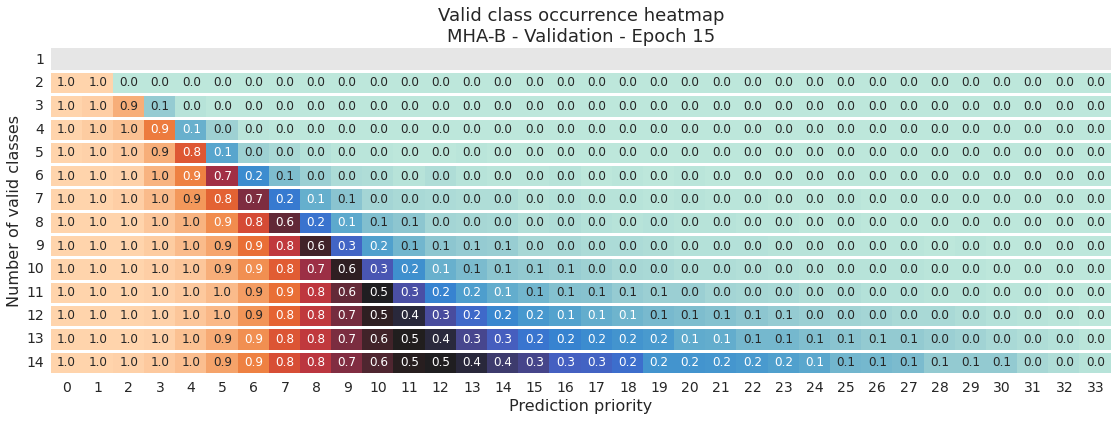

Epoch with lowest val_loss: 13


,mode,epoch,n_valid,h_0,h_1,h_2,h_3,h_4,h_5,h_6,...,h_24,h_25,h_26,h_27,h_28,h_29,h_30,h_31,h_32,h_33
0,0,0,1,0.750000,0.071429,0.035714,0.035714,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000
1,0,0,2,0.724623,0.665047,0.042189,0.026847,0.026336,0.026592,0.030683,...,0.009205,0.014574,0.014830,0.018665,0.017131,0.016620,0.011506,0.017643,0.009460,0.010483
2,0,0,3,0.741636,0.683353,0.536899,0.107587,0.070671,0.057264,0.049585,...,0.020171,0.019961,0.021437,0.023809,0.023703,0.023756,0.020751,0.018397,0.015339,0.011931
3,0,0,4,0.761319,0.723174,0.668251,0.540076,0.142268,0.098325,0.080051,...,0.024619,0.024084,0.023443,0.023858,0.022437,0.021663,0.020223,0.018959,0.014841,0.011508
4,0,0,5,0.775312,0.737843,0.697916,0.626748,0.473025,0.196416,0.138315,...,0.032578,0.032223,0.031596,0.032409,0.031180,0.030306,0.027164,0.024666,0.019507,0.015733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,1,29,10,0.999640,0.998741,0.990104,0.977330,0.946024,0.901403,0.824037,...,0.028248,0.020691,0.017812,0.018352,0.012415,0.013134,0.011875,0.006837,0.005757,0.002339
836,1,29,11,1.000000,0.998899,0.995595,0.988162,0.967515,0.923606,0.863317,...,0.041294,0.033586,0.026841,0.024776,0.019683,0.017206,0.013902,0.011149,0.009360,0.004542
837,1,29,12,0.999863,0.999041,0.995892,0.988087,0.968643,0.922087,0.858414,...,0.070930,0.067917,0.054498,0.050801,0.045735,0.038614,0.027386,0.027112,0.018622,0.011639
838,1,29,13,1.000000,0.998973,0.992811,0.986136,0.963800,0.916560,0.862388,...,0.101412,0.086521,0.073171,0.073684,0.068806,0.062644,0.047240,0.043389,0.037997,0.020539


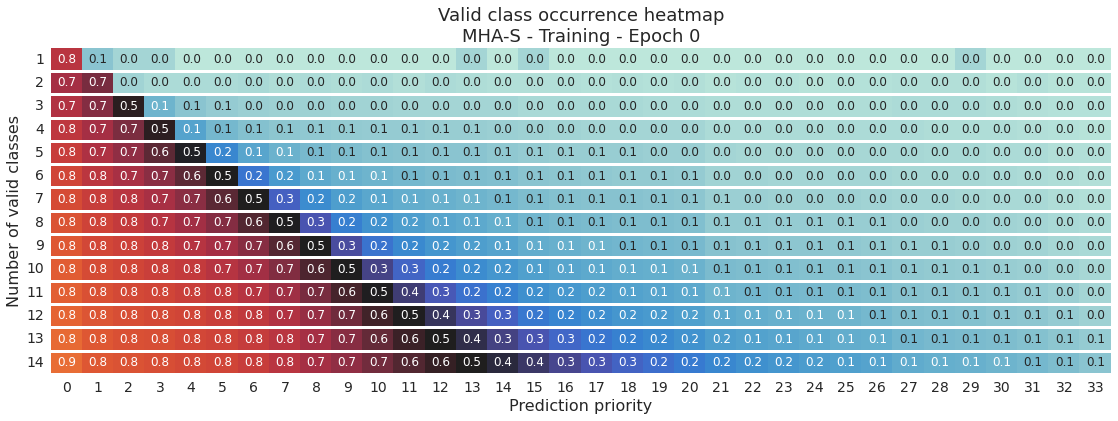

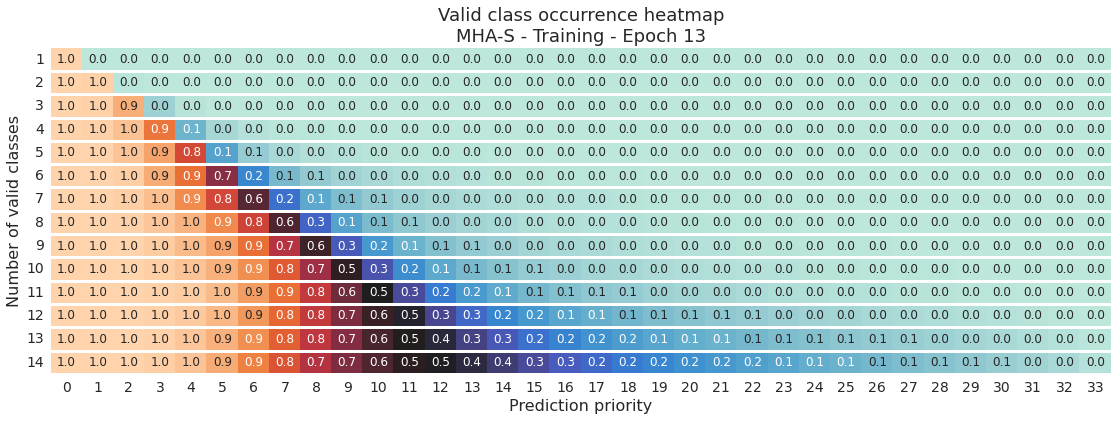

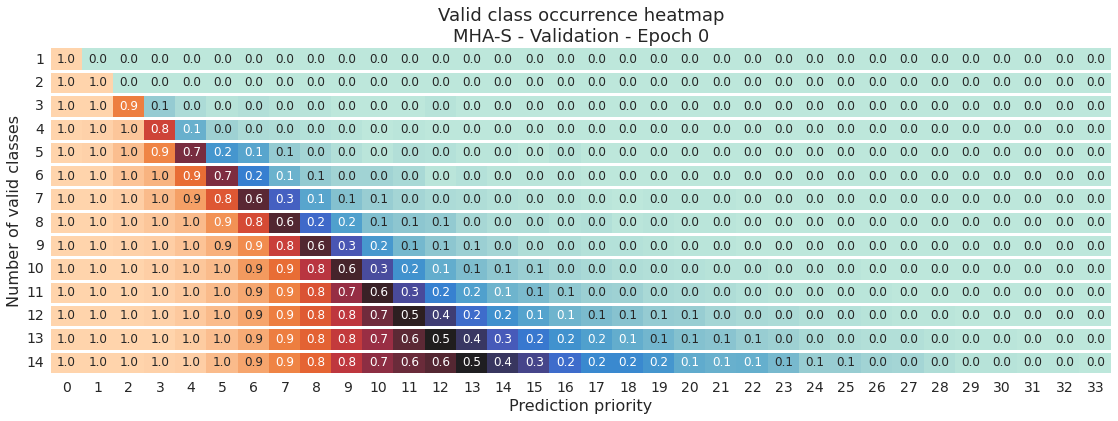

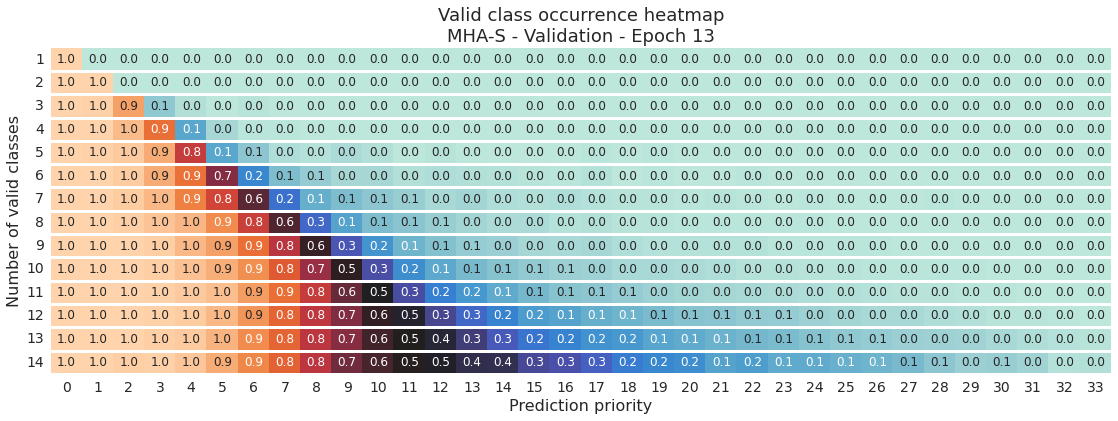

In [15]:
# model_name = 'MHA-S'  # SWITCH MODEL HERE

for model_name in model_paths:

    heatmap_df = pd.read_csv(model_paths[model_name] / 'heatmap.csv')
    heatmap_df = heatmap_df.astype({'mode': 'int32', 'epoch': 'int32', 'n_valid': 'int32'})

    best_epoch = new[new.model == model_name]['epoch'].values[0]

    print("Epoch with lowest val_loss:", best_epoch)
    display(heatmap_df)

    graph_heatmap(heatmap_df, model_name, 0, 0)
    graph_heatmap(heatmap_df, model_name, 0, best_epoch)  # LOAD CORRECT EPOCH!

    graph_heatmap(heatmap_df, model_name, 1, 0)
    graph_heatmap(heatmap_df, model_name, 1, best_epoch)  # LOAD CORRECT EPOCH!

# INVERSION LATEX

In [17]:
def inversion_latex(inversion_count_df, inversion_stats_df, mode='training'):
    
    selected_mode = 0 if mode == 'training' else 1
    
    # Initial Values
    inversion_training_0 = inversion_stats_df[
        (inversion_stats_df['mode'] == selected_mode) &
        (inversion_stats_df['epoch'] == 0)
    ][['n_valid', 'max','mean', 'median']]

    # Best Values
    inversion_training_1 = inversion_stats_df[
        (inversion_stats_df['mode'] == selected_mode) &
        (inversion_stats_df['epoch'] == best_epoch)
    ][['n_valid', 'max', 'mean', 'median']]
    inversion_training_1 = inversion_training_1.rename(columns={'max': 'max_2', 'median': 'median_2', 'mean': 'mean_2'})
    
    # Reset index or else we cannot merge correctly
    inversion_training_0.reset_index(drop=True, inplace=True)
    inversion_training_1.reset_index(drop=True, inplace=True)

    # Merge above values with Count Table
    column_name = 'training_count' if selected_mode == 0 else 'validation_count'
    xx = pd.concat([inversion_training_0, inversion_count_df[column_name]], axis=1)
    xx = pd.merge(xx,  inversion_training_1)
    xx = xx[['n_valid',column_name, 'max', 'max_2', 'mean', 'mean_2', 'median', 'median_2']]
        
    xx = xx.replace(-1, pd.NA)
    
    # Make it Nullable
    xx = xx.astype({
        'n_valid'  : 'Int64',
        'max'      : 'Int64',
        'max_2'    : 'Int64',
        'mean'     : 'Float64',
        'mean_2'   : 'Float64',
        'median'   : 'Int64',
        'median_2' : 'Int64',
    })
    


#     xx['max'] = xx['max'].astype('Int64')  # Oddly changes to float in previous step
#     xx['median'] = xx['median'].astype('Int64')  # Oddly changes to float in previous step


    latex_inversion_table = xx.to_latex(index=False, 
                                        index_names=False, 
                                        float_format="%.2f", 
                                        na_rep='-'
#                                         bold_rows=True,
#                                         header=['Number of valid classes', 'Median inversions', 'Mean number of inversions']
                                       )

    print(latex_inversion_table.replace('<NA>', '   -'))

CHANGE EPOCH TO: 13
ONLY COPY VALUES, COLUMN HEADERS IS WRONG
TRAINING TABLE:
\begin{tabular}{rrrrrrrr}
\toprule
 n\_valid &  training\_count &  max &  max\_2 &  mean &  mean\_2 &  median &  median\_2 \\
\midrule
       1 &              28 &   29 &      0 &  2.29 &    0.00 &       0 &         0 \\
       2 &            3911 &   63 &      3 &  8.66 &    0.01 &       0 &         0 \\
       3 &           56912 &   93 &     23 & 13.21 &    0.11 &       1 &         0 \\
       4 &          159024 &  119 &     28 & 15.56 &    0.37 &       1 &         0 \\
       5 &          231045 &  144 &     56 & 19.88 &    0.98 &       4 &         0 \\
       6 &          485642 &  168 &     62 & 22.13 &    2.16 &       4 &         0 \\
       7 &          790376 &  184 &     73 & 24.50 &    3.56 &       5 &         1 \\
       8 &         1086816 &  208 &    117 & 28.08 &    3.81 &       7 &         1 \\
       9 &         1927665 &  221 &    109 & 30.73 &    5.13 &       7 &         2 \\
      10 &   

# Inversion
Originally from `model.ipynb`

In [25]:
# model_name = 'MHA-S'  # SWITCH MODEL HERE

for model_name in model_paths:
    best_epoch = new[new.model == model_name]['epoch'].values[0]

    inversion_count_df = pd.read_csv(model_paths[model_name] / 'inversions_counts.csv')  # Needed for next step
    inversion_count_df = inversion_count_df.iloc[1:].reset_index(drop=True)

    inversion_stats_df = pd.read_csv(model_paths[model_name] / 'inversions.csv')
    inversion_stats_df = inversion_stats_df.fillna(-1)  # Replaces NAN with -1
    inversion_stats_df = inversion_stats_df.astype({
        'median': int,
        'n_valid': int,
    })
    
    print(model_name)
#     display(inversion_count_df)
#     display(inversion_stats_df)
    print('ONLY COPY VALUES, COLUMN HEADERS IS WRONG')

    print("TRAINING TABLE:")
    print('\tCHANGE EPOCH TO:', best_epoch)

    inversion_latex('training')
    print('ONLY COPY VALUES, COLUMN HEADERS IS WRONG')
    print("VALIDATION TABLE:")
    inversion_latex('validation')

FFO-B
ONLY COPY VALUES, COLUMN HEADERS IS WRONG
TRAINING TABLE:
	CHANGE EPOCH TO: 17
\begin{tabular}{rrrrrrrr}
\toprule
 n\_valid &  training\_count &  max &  max\_2 &   mean &  mean\_2 &  median &  median\_2 \\
\midrule
       1 &              47 &   32 &      3 &  13.43 &    0.51 &      10 &         0 \\
       2 &            7845 &   64 &     33 &  25.93 &    0.46 &      26 &         0 \\
       3 &          114933 &   93 &     40 &  33.92 &    1.23 &      32 &         0 \\
       4 &          318664 &  119 &     52 &  40.72 &    2.27 &      39 &         1 \\
       5 &          463980 &  145 &     55 &  50.13 &    3.58 &      48 &         2 \\
       6 &          970986 &  166 &     66 &  57.37 &    5.33 &      55 &         4 \\
       7 &         1580104 &  187 &     71 &  63.52 &    6.76 &      61 &         5 \\
       8 &         2173605 &  203 &    100 &  71.35 &    7.26 &      68 &         6 \\
       9 &         3855827 &  223 &     90 &  78.83 &    8.55 &      75 &         7

<Figure size 720x360 with 0 Axes>

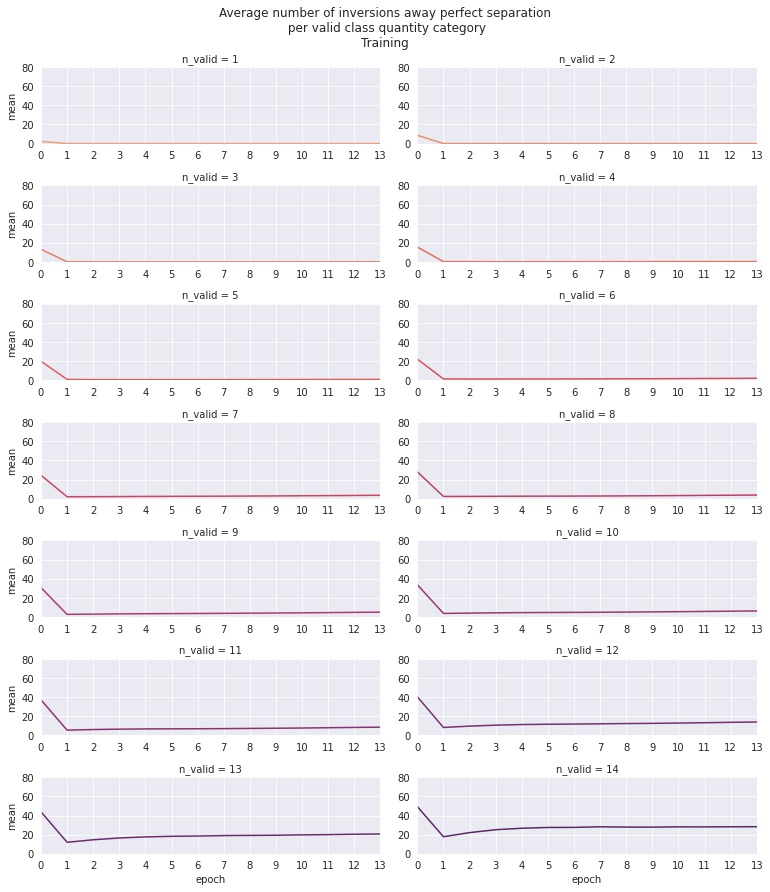

<Figure size 720x360 with 0 Axes>

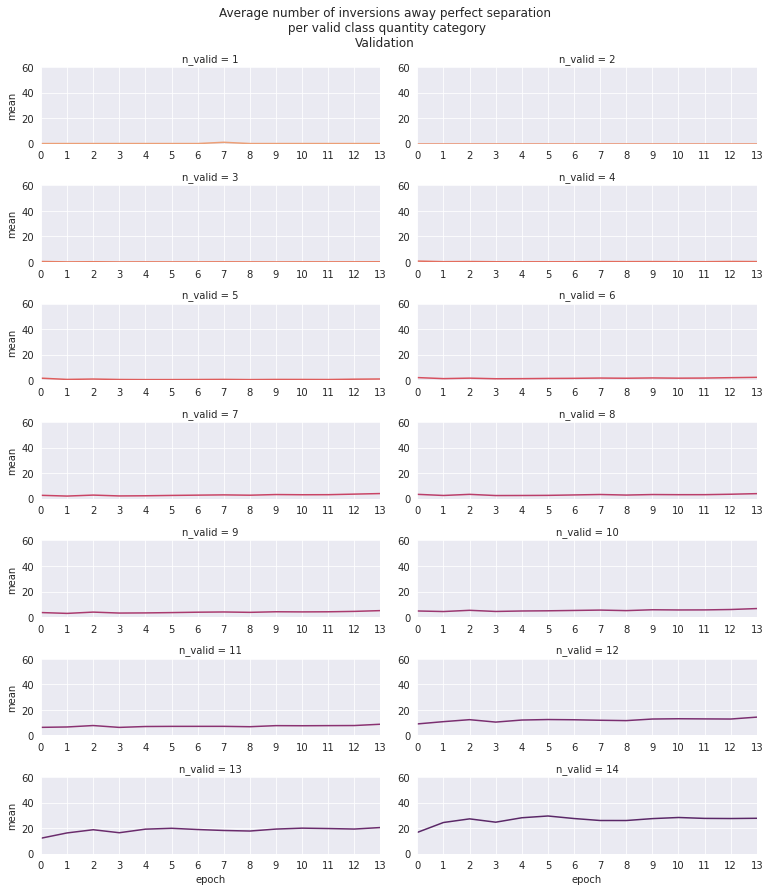

In [18]:
def graph_inversion_facetgrid(df, mode: int):
    
    sorted_df = df[(df['mode'] == mode)]
    
    sns.set_style("darkgrid")

    plt.figure(figsize=(10, 5))

    g = sns.FacetGrid(sorted_df, 
                      col="n_valid", 
                      height=1.8, 
                      aspect=3, 
                      col_wrap=2, 
                      sharex=False, 
                      sharey=False,
                      palette="flare",
                      hue='n_valid',
    #                   legend_out=True,
    #                   margin_titles=True
                     )

    g.set(
        xlim=(0, best_epoch), 
        ylim=(0, sorted_df['mean'].max()), 
        xticks=np.arange(0, best_epoch + 1, 1), 
        yticks=np.arange(0, sorted_df['mean'].max() + 40, 20)
    )

    g.fig.suptitle(f"Average number of inversions away perfect separation\n per valid class quantity category\n{'Training' if mode == 0 else 'Validation'}")

    g.map(sns.lineplot, 'epoch', 'mean')

    plt.show()
    
graph_inversion_facetgrid(inversion_stats_df, 0)
graph_inversion_facetgrid(inversion_stats_df, 1)

In [19]:
inversion_stats_df[(inversion_stats_df['mode'] == 1)]

,mode,epoch,n_valid,min,max,mean,median
14,1,0,1,0,0,0.000000,0
15,1,0,2,0,0,0.000000,0
16,1,0,3,0,10,0.351562,0
17,1,0,4,0,16,0.666667,0
18,1,0,5,0,20,1.684444,0
...,...,...,...,...,...,...,...
835,1,29,10,0,95,11.678481,7
836,1,29,11,0,101,14.564212,11
837,1,29,12,0,115,21.116254,18
838,1,29,13,0,118,26.765340,23


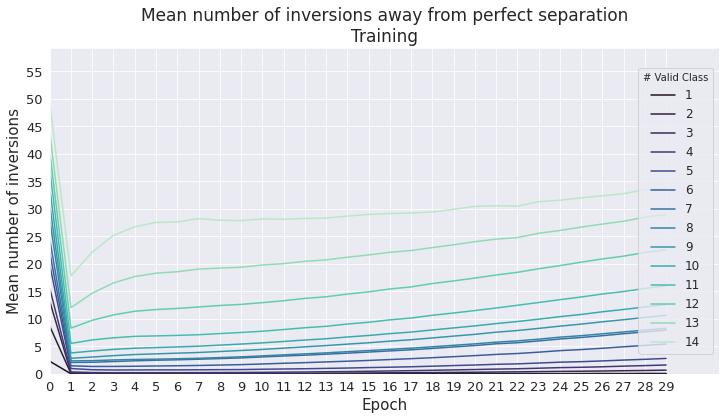

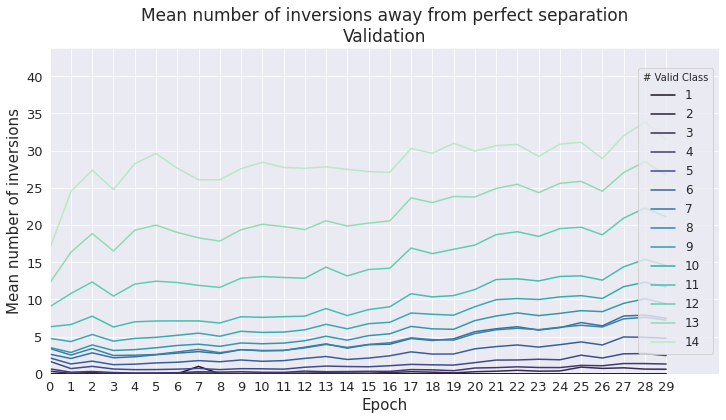

In [20]:
def create_inversion_lineplot(df, mode: int):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 12
    figsize = (12, 6)
    
    sorted_df = df[(df['mode'] == mode)]
#     sorted_df = sorted_df[(df['epoch'] <= best_epoch)]
    
    sns.set_style("darkgrid")

    plt.figure(figsize=figsize)

    ax = sns.lineplot(data=sorted_df, 
                 x='epoch', 
                 y='mean', 
                 hue='n_valid',
#                  style='n_valid',
    #              markers=True,
                 palette=sns.color_palette("mako", n_colors=14)
,
                )

#     ax.set(
# #         title=f"Average number of inversions away perfect separation per valid class quantity category\n{'Training' if mode == 0 else 'Validation'}",
# #         xlim=(0, sorted_df['epoch'].max() + 2), 
# #         ylim=(0, sorted_df['mean'].max() + 10), 
#     )
    
    #  per valid class quantity category
    plt.title(f"Mean number of inversions away from perfect separation\n{'Training' if mode == 0 else 'Validation'}",
              fontsize=title_fontsize)
    
    plt.ylabel('Mean number of inversions', fontsize=label_fontsize)
    plt.xlabel('Epoch', fontsize=label_fontsize)
    
    plt.xticks(np.arange(0, sorted_df['epoch'].max() + 1, 1),  fontsize=ticks_fontsize)
    plt.yticks(np.arange(0, sorted_df['mean'].max() + 10, 5), fontsize=ticks_fontsize)
    plt.xlim(0, sorted_df['epoch'].max() + 2.5)
    plt.ylim(0, sorted_df['mean'].max() + 10)
    
    plt.legend(title='# Valid Class', 
               loc='center right',
               fontsize=legend_fontsize)

    
    plt.savefig(Path('figures') / f"{model_name}_inversion_{'training' if mode == 0 else 'validation'}.png", bbox_inches='tight')
    
    plt.show()
    
create_inversion_lineplot(inversion_stats_df, 0)
create_inversion_lineplot(inversion_stats_df, 1)

# Valid / Invalid Prediction Propability Sum

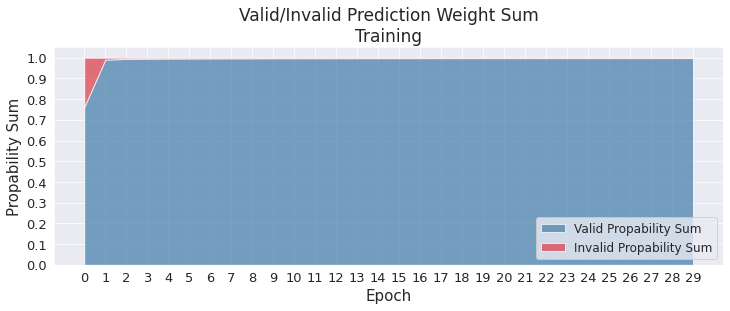

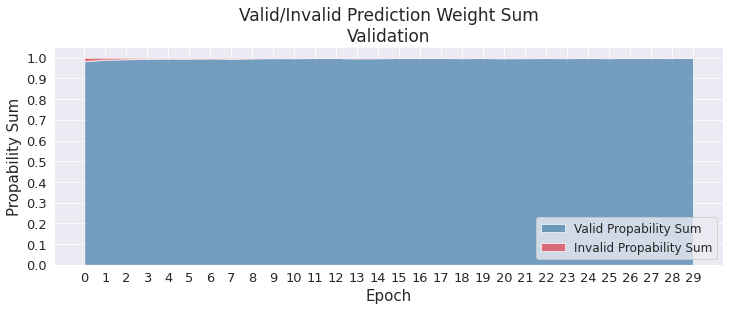

In [21]:
model_name = 'MHA-S'  # SWITCH MODEL HERE

# best_epoch = new[new.model == model_name]['epoch'].values[0]

summary = pd.read_csv(model_paths[model_name] / 'summary.csv')  # Needed for next step

def graph_weigh_sum_epochwise(weigh_sum_column, title, mode):
    
    title_fontsize = 17
    ticks_fontsize = 13
    label_fontsize = 15
    legend_fontsize = 12
    figsize = (12, 4)
    
    x = range(0, len(weigh_sum_column))
    y = [weigh_sum_column, (1 - weigh_sum_column)]

    figure = plt.figure(figsize=figsize)

    plt.stackplot(x, y, 
                  labels=['Valid Propability Sum', 'Invalid Propability Sum'], 
                  alpha=0.7,
                  colors=diverging_palette_light)
    
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=ticks_fontsize)
    plt.xticks(np.arange(0, len(weigh_sum_column), 1), fontsize=ticks_fontsize)

    plt.legend(loc='lower right', fontsize=legend_fontsize)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Epoch', fontsize=label_fontsize)
    plt.ylabel('Propability Sum', fontsize=label_fontsize)
    
    plt.savefig(Path('figures') / f"{model_name}_probability_sum_{'training' if mode == 0 else 'validation'}.png", bbox_inches='tight')

    plt.show()

graph_weigh_sum_epochwise(summary['train_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nTraining", 0)
graph_weigh_sum_epochwise(summary['val_average_valid_weight_sum'], "Valid/Invalid Prediction Weight Sum\nValidation", 1)

# Best Discard Format [DEPRECATED?]

### TODO: LOAD CHOSEN MODEL

In [ ]:
df_pools_only = pd.read_csv('model_checkpoints/mha_pool_balanced_val_2021-04-30/summary.csv')
df_pools_meld = pd.read_csv('model_checkpoints/mha_pool_imbalanced_val_2021-05-01/summary.csv')

In [ ]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df_pools_only['epoch'], df_pools_only['val_loss'], label='POOLS-ONLY Dataset')
plt.plot(df_pools_meld['epoch'], df_pools_meld['val_loss'], label='POOLS+MELDS Dataset')

plt.title('Discard Format Comparison: POOLS-ONLY vs. POOLS+MELDS\nValidation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xticks(df1['epoch'])

plt.show()

In [ ]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df_pools_only['epoch'], df_pools_only['val_acc'], label='POOLS-ONLY Dataset')
plt.plot(df_pools_meld['epoch'], df_pools_meld['val_acc'], label='POOLS+MELDS Dataset')

plt.title('Discard Format Comparison: POOLS-ONLY vs. POOLS+MELDS\nValidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.xticks(df1['epoch'])

plt.show()

# Hand Drawer

In [ ]:
import utilities.mahjong_drawer.mahjong_drawer.mahjong_drawer_module as drawer

md = drawer.MahjongDrawer('utilities/mahjong_drawer/mahjong_drawer/svg')
md.add_hand("345m3368p5567s777h", 'out/random_hand.svg')

In [ ]:
arr = np.array([[0,0,1,1,1,0,0,0,0,
                 0,0,2,0,0,1,0,1,0,
                 0,0,0,0,2,1,1,0,0,
                 0,0,0,0,
                 0,0,3]])

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

heatmap_params = dict(
        annot=True,
        fmt='g',
        square=False,
        xticklabels=ticks_tiles_oneline,
        yticklabels=[''],     
        annot_kws={"fontsize": 17},
        robust=True,        
        cbar=False,  # cbar param is always true, but we instead turn it invisible later if cbar is disabled
        linewidths=3,
        linecolor='black'
#         cbar_ax=ax2,
#         cbar_kws=dict(
#             shrink=0.3, 
#             label='Category code',
#         )
    )

heatmap_params.update(dict(
    norm=matplotlib.colors.BoundaryNorm([-128, 0, 1, 2, 3, 4, 128], 7),
    cmap=sns.color_palette(["#000000",
                            "#FFFFFF", 
                            "#EA2027", 
                            "#EE5A24", 
                            "#F79F1F", 
                            "#FFC312", ])))

fig = plt.figure(figsize=(17, 0.6))
ax = sns.heatmap(arr, **heatmap_params)

plt.xticks(fontsize=14, position=(0, -1))

plt.savefig('out/34array.svg', bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
import svgutils.compose as sc

x = 30
y = 8

list_of_svgs = [
    sc.Panel(sc.SVG("out/34array.svg").scale(1)),
]

for i in range(34):
    list_of_svgs.append(sc.Panel(sc.SVG(get_tile_svg(i)).scale(0.11).move(x, 12)))
    x += 27.9


sc.Figure("25.3cm", "4cm", *list_of_svgs).save("out/compose.svg")

SVG('out/compose.svg')

In [ ]:
import utilities.mahjong_drawer.mahjong_drawer.mahjong_drawer_module as drawer
from IPython.display import SVG, HTML, Image

md = drawer.MahjongDrawer('utilities/mahjong_drawer/mahjong_drawer/svg')
# md.add_hand("1m 2m 3m 4m 5m 6m 7m 8m 9m 1p 2p 3p 4p 5p 6p 7p 8p 9p 1s 2s 3s 4s 5s 6s 7s 8s 9s 1h 2h 3h 4h 5h 6h 7h", 'out/34test.svg')
md.add_hand("1m", 'out/34test.svg')

display(Image(url='out/34test.svg', width=20))

In [ ]:
def get_tile_svg(class_number: int):
    """ Faster fetch for single tile. """
    svg_folder = "utilities/mahjong_drawer/mahjong_drawer/svg/"
    if class_number < 9:
        return svg_folder + "tile_m{}!.svg".format(class_number + 1)
    elif 9 <= class_number < 18:
        return svg_folder + "tile_p{}!.svg".format(class_number - 9 + 1)
    elif 18 <= class_number < 27:
        return svg_folder + "tile_s{}!.svg".format(class_number - 18 + 1)
    else:
        return svg_folder + "tile_h{}!.svg".format(class_number - 27 + 1)

In [ ]:
data = np.arange(1, 35, 1)
fig = plt.figure(figsize=(18.5, 1))
plt.bar(range(34), data, width=0.4)

plt.yticks(np.arange(0, 34, 6))
plt.xticks(range(34), ticks_tiles_oneline, rotation=90, position=(0, -0.6))
plt.xlim(-1, 35)

fig.patch.set_visible(False)
ax = plt.gca()
# ax.axis('off')

plt.savefig('out/34bar.svg', bbox_inches='tight', transparent=False)


plt.show()

In [ ]:
import svgutils.compose as sc

x = 64.3
y = 8

list_of_svgs = [
    sc.Panel(sc.SVG("out/34bar.svg").scale(1)),
]

for i in range(34):
    list_of_svgs.append(sc.Panel(sc.SVG(get_tile_svg(i)).scale(0.11).move(x, 34)))
    x += 28.68


sc.Figure("27cm", "4cm", *list_of_svgs).save('out/composed_bar.svg')

SVG('out/composed_bar.svg')

In [ ]:
def draw_34_array(input_array: np.array, title=None, cbar=True, color_scheme='white', grid_color='black'):
    

    
    # Common Params
    heatmap_params = dict(
        ax=ax1,
        annot=True,
        fmt='g',
#         mask=mask,
        square=False,
        xticklabels=ticks_tiles_oneline,
        yticklabels=yticklabels,     
        annot_kws={"fontsize": annot_fontsize},
        robust=True,        
        cbar=True,  # cbar param is always true, but we instead turn it invisible later if cbar is disabled
        cbar_ax=ax2,
        cbar_kws=dict(
            shrink=0.3, 
            label='Category code',
        )
    )
    
    # Extension of Params
    if color_scheme == 'attention':
        heatmap_params.update(dict(
            cmap="icefire",
#             vmin=-10,
#             vmax=10,
        ))
    elif color_scheme == 'plain':
#         mask = np.zeros((11, 34))
#         mask[0, 14:34] = 1
        heatmap_params.update(dict(
#             mask=mask,
            norm=matplotlib.colors.BoundaryNorm([-128, 0, 1, 2, 3, 4, 128], 7),
            cmap=sns.color_palette(["#000000",
                                    "#FFFFFF", 
                                    "#EA2027", 
                                    "#EE5A24", 
                                    "#F79F1F", 
                                    "#FFC312", ])))
    else:
        
        heatmap_params.update(dict(cmap=sns.color_palette(["#FFFFFF"])))  # All white
        
        # Show Meta Data vs Tile Data (UNCOMMENT TO USE THIS!)
#         heatmap_params.update(dict(
#         norm=matplotlib.colors.BoundaryNorm([1, 34, 45], 3),
#         cmap=sns.color_palette([
#             "#e74c3c", # Metadata Color
#             "#FFFFFF", # Ignore
#             "#2980b9", # Tile Data Color
#         ])))
        

        
    if grid_color == None:
        linewidths = 0
    else:
        heatmap_params.update(dict(linewidths=1, linecolor=grid_color))
    
    # Heatmap Creation
    ax1 = sns.heatmap(pd.DataFrame(input_array), **heatmap_params)

#     twin1.set_xlabel("Metadata Labels")
    twin1.set_xlim(ax1.get_xlim())
    twin1.set_xticks(ax1.get_xticks())
    metadata_labels = [
        'Round wind',
        'Dealer',
        'POV player',
        '# honba sticks',
        '# riichi sticks',
        '# wall tiles',
        'P0 score',
        'P1 score',
        'P2 score',
        'P3 score',
        'P0 riichi status',
        'P1 riichi status',
        'P2 riichi status',
        'P3 riichi status',
    ] + ['Padding' for _ in range(20)]
    twin1.set_xticklabels(labels=metadata_labels, rotation='vertical')
    twin1.grid(False)  # Remove weird white vertical lines that sometimes appears

    ax1.hlines(range(1, 2), -0.5, 34.5, linewidth=7, color=grid_color)  # Metadata separator line

    # Ticks Configuration
    ax1.tick_params(left=False, bottom=False, top=False, labelsize=tick_fontsize)
    twin1.tick_params(top=False, labelsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    
    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    
    if title:
        plt.title(title)
    
    if not cbar:
        ax2.set_visible(False)

    plt.show()


# Index Heatmap
generate_input_heatmap(np.arange(0, 374).reshape(11, 34), cbar=False, color_scheme='white', title=None)
generate_input_heatmap(np.arange(0, 374).reshape(11, 34), cbar=False, color_scheme='attention', title=None)


# Validation Heatmaps
model.eval()

n_inputs = 5
x = validation_dataset[100:105]['X'].to(DEVICE)  # GET CORRECT DATA
x = x.reshape(1, x.shape[0], 374)
attn_output, _ = model.mha1(query=x, key=x, value=x, need_weights=None)
attn_output = attn_output.reshape(n_inputs, 374)

for i, attention_values in enumerate(attn_output):
    
    pretty_print_x(x[0, i])

    
    x_arr = x[0, i].cpu().detach().numpy().reshape(11, 34)
    generate_input_heatmap(x_arr, cbar=False, color_scheme='plain')

    
    attention_result = attention_values.reshape(11, 34).cpu().detach().numpy()
    attention_result = np.around(attention_result, decimals=0)
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color=None)
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color='white')
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color='black')

    break # TODO: REMOVE!